# Лабораторная работа 3
## Деревья решений. Классификатор пола по голосу

## Выполнил: __Щеткин Дмитрий Сергеевич__

группа 2.1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree, model_selection, metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

In [2]:
voice_data = pd.read_csv('data/voice_gender.csv')
voice_data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402905,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [3]:
# проверка на пропуски
voice_data.isnull().sum().sum()

np.int64(0)

In [4]:
# преобразование целевой переменной в числовую
voice_data['label'] = voice_data['label'].map({'male': 0, 'female': 1})
X = voice_data.drop('label', axis=1)
y = voice_data['label']

# формирование обучающей и тестовой выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')

Train shape: (2534, 20)
Test shape: (634, 20)


**Задание 1**: Решающие пни (глубина 1)

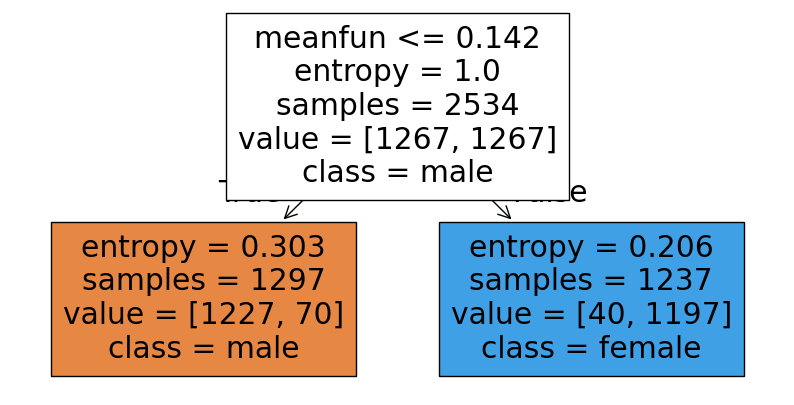

In [5]:
# дерево решений глубиной 1
stump = DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0)
stump.fit(X_train, y_train)

plt.figure(figsize=(10,5))
plot_tree(stump, feature_names=X.columns, class_names=['male', 'female'], filled=True)
plt.show()

Визуальный анализ:
- Решающее правило в корневой вершине построено на основе фактора meanfun (средняя основная частота в акустическом спектре)
- Оптимальное пороговое значение для данного фактора равно 0.142

In [6]:
# фактор и пороговое значение в корневой вершине
feature = stump.tree_.feature[0]
threshold = stump.tree_.threshold[0]
print(f'Фактор: {X.columns[feature]}')
print(f'Пороговое значение: {threshold:.3f}')

Фактор: meanfun
Пороговое значение: 0.142


In [7]:
# доля наблюдений, содержащихся в обучающей выборке (для которых условие выполняется)
left_indices = X_train[X_train.iloc[:, feature] <= threshold].index
percentage = len(left_indices) / len(X_train) * 100
print(f'Доля наблюдений: {percentage:.1f}')

Доля наблюдений: 51.2


In [8]:
# значение метрики accuracy на тестовой выборке
acc = metrics.accuracy_score(y_test, stump.predict(X_test))
print(f'Accuracy: {acc:.3f}')

Accuracy: 0.945


**Задание 2**: Дерево решений глубины 2

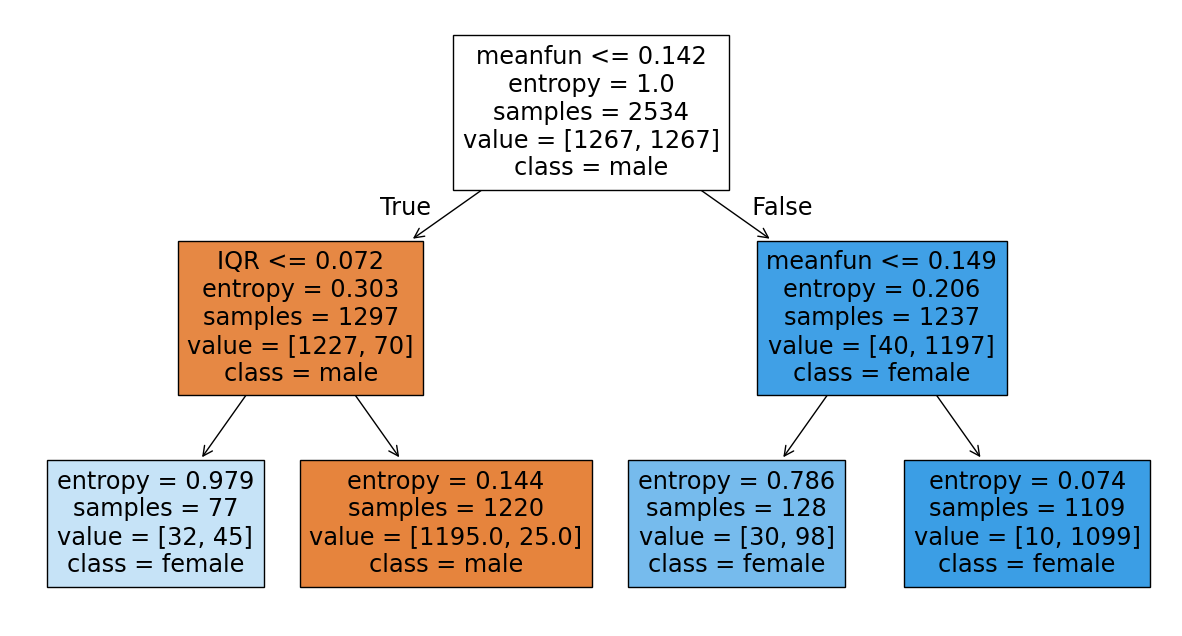

In [9]:
# дерево решений глубиной 2
tree2 = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=0)
tree2.fit(X_train, y_train)

plt.figure(figsize=(15,8))
plot_tree(tree2, feature_names=X.columns, class_names=['male', 'female'], filled=True)
plt.show()

Визуальный анализ:
- Используемые факторы: meanfun (средняя основная частота в акустическом спектре) и IQR (межквартильный размах частот)
- В дереве 3 листа содержат class = female

In [10]:
# значение метрики accuracy на тестовой выборке
acc = metrics.accuracy_score(y_test, tree2.predict(X_test))
print(f'Accuracy: {acc:.3f}')

Accuracy: 0.959


**Задание 3**: Дерево решений без ограничения глубины

In [11]:
# дерево решений без ограничения глубины
tree_full = DecisionTreeClassifier(criterion='entropy', random_state=0)
tree_full.fit(X_train, y_train)

print(f'1. Глубина: {tree_full.get_depth()}')

print(f'2. Количество листьев: {tree_full.get_n_leaves()}')

acc_train = metrics.accuracy_score(y_train, tree_full.predict(X_train))
acc_test = metrics.accuracy_score(y_test, tree_full.predict(X_test))
print(f'3. Accuracy train: {acc_train:.3f}, test: {acc_test:.3f}')

1. Глубина: 10
2. Количество листьев: 50
3. Accuracy train: 1.000, test: 0.962


**Задание 4**: Подбор гиперпараметров (GridSearchCV)

In [12]:
# cетка параметров
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [4, 5, 6, 7, 8, 9, 10],
    'min_samples_split': [3, 4, 5, 10]
}
cv = model_selection.StratifiedKFold(n_splits=5)

grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, scoring='accuracy', cv=cv)
grid.fit(X_train, y_train)
print('Оптимальные параметры:', grid.best_params_)

Оптимальные параметры: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 4}


Таким образом:
1. Наилучшая модель использует Энтропию Шеннона
2. Оптимальная максимальная глубина: 6
3. Минимальное количество объектов, необходимое для разбиения: 4


In [13]:
best_model = grid.best_estimator_
print(f'Train accuracy: {metrics.accuracy_score(y_train, best_model.predict(X_train)):.3f}')
print(f'Test accuracy: {metrics.accuracy_score(y_test, best_model.predict(X_test)):.3f}')

Train accuracy: 0.992
Test accuracy: 0.967


**Задание 5**: Важность факторов

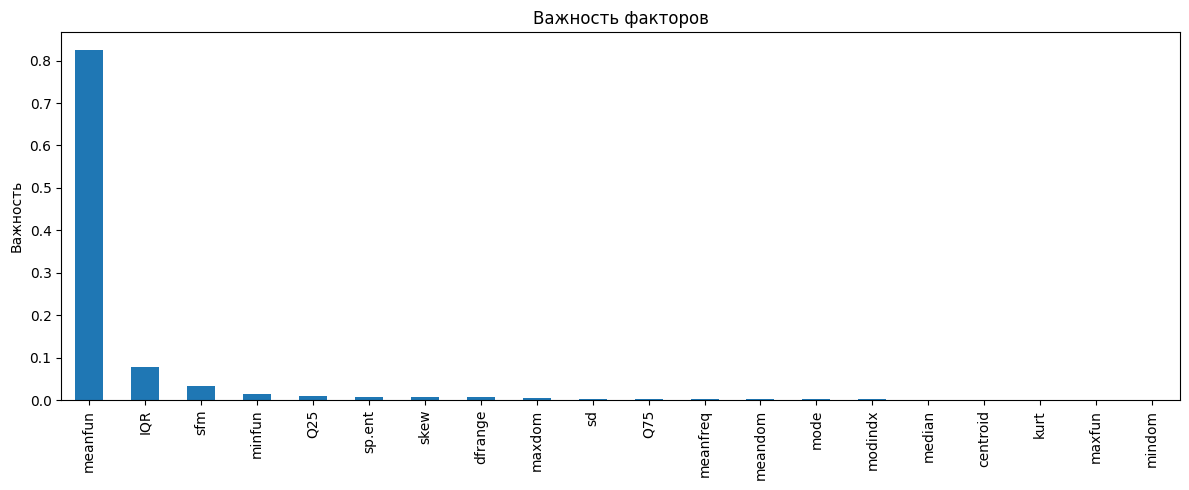

,0
meanfun,0.825334
IQR,0.077586
sfm,0.032071


In [14]:
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(12,5), title='Важность факторов')
plt.ylabel('Важность')
plt.tight_layout()
plt.show()
importances.sort_values(ascending=False).head(3)

Топ 3 наиболее важных факторов:
1. meanfun (средняя основная частота в акустическом спектре)
2. IQR (межквартильный размах частот)
3.  sfm (спектральная равномерность)